# Machine Learning in Exoplanet Exploration
### Machine Learning Engineer Nanodegree Capstone Project 

In [48]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

# Embed plots in the notebook
%matplotlib inline

# Add extension to reload modules automatically, in case they have been updated
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

### Kaggle dataset exploration

In [2]:
# Load training and test datasets
try:
    flux_train = pd.read_csv("Data\light_curve_Train.csv")
    print('Training dataset loaded: {} samples with {} features.'.format(*flux_train.shape))
except:
    print("Training dataset could not be loaded.")
    
try:
    flux_test = pd.read_csv("Data\light_curve_Test.csv")
    print('Test dataset loaded: {} samples with {} features.'.format(*flux_test.shape))
except:
    print("Test dataset could not be loaded.")

Training dataset loaded: 5087 samples with 3198 features.
Test dataset loaded: 570 samples with 3198 features.


In [3]:
# Seperate labels from other features
y_flux_train = flux_train['LABEL']
x_flux_train = flux_train.drop(['LABEL'],axis=1)

y_flux_test = flux_test['LABEL']
x_flux_test = flux_test.drop(['LABEL'],axis=1)

Confirmed exoplanet-stars in training set:  37
Confirmed exoplanet-stars in test set:  5


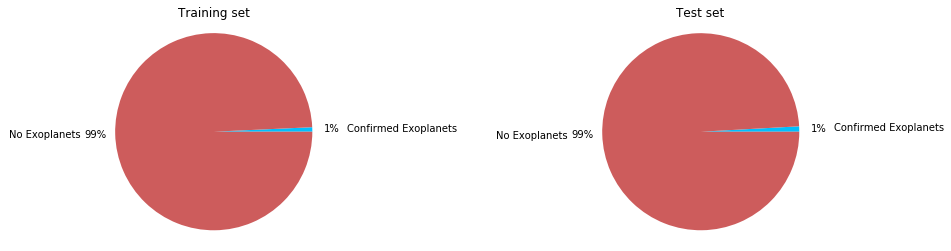

In [4]:
# Count number of exoplanet stars in the training and test datasets
n_exoplanets_train = y_flux_train[y_flux_train == 2].count()
n_exoplanets_test = y_flux_test[y_flux_test == 2].count()

print("Confirmed exoplanet-stars in training set: ", n_exoplanets_train)
print("Confirmed exoplanet-stars in test set: ", n_exoplanets_test)

# Plot pie chart for exoplanet vs non-exoplanet stars in the training and test datasets
fig = plt.figure(figsize=(16,4))
colors = ['deepskyblue','indianred']

plt.subplot(1,2,1)
plt.pie([n_exoplanets_train, y_flux_train.size-n_exoplanets_train], colors=colors, 
        labels=['Confirmed Exoplanets', 'No Exoplanets'], autopct='%1.0f%%', pctdistance=1.2, labeldistance=1.35) 
plt.title('Training set')
plt.axis('equal')

plt.subplot(1,2,2)
plt.pie([n_exoplanets_test, y_flux_test.size-n_exoplanets_test], colors=colors, 
        labels=['Confirmed Exoplanets', 'No Exoplanets'], autopct='%1.0f%%', pctdistance=1.2, labeldistance=1.35) 
plt.title('Test set')
plt.axis('equal')

plt.show()

In [5]:
x_flux_train.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


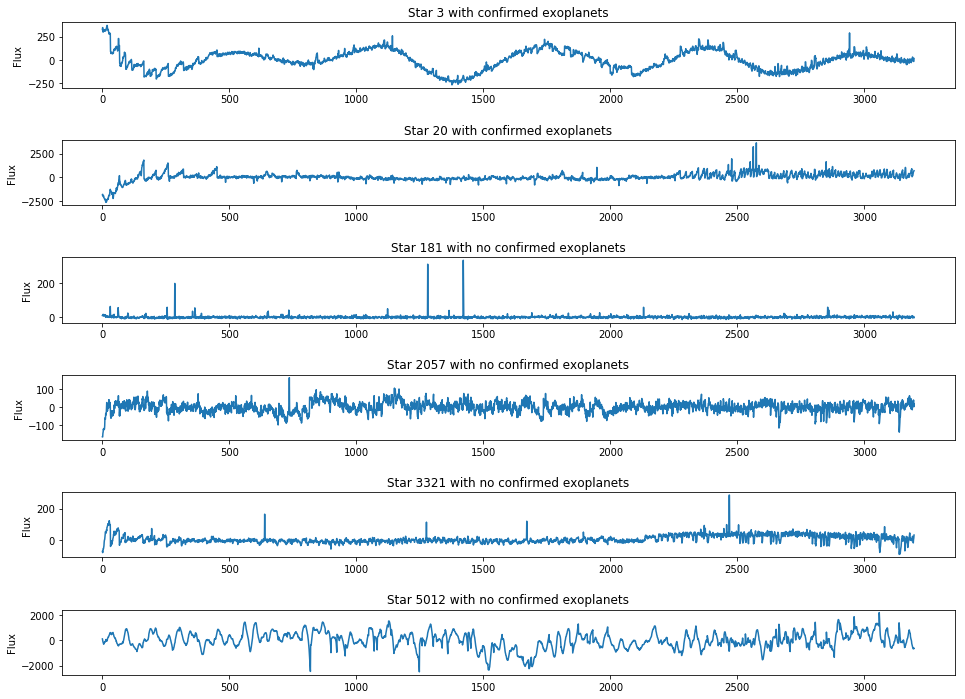

In [6]:
# Choose samples to visualise
samples = [3,20,181,2057,3321,5012]
n_samples = len(samples)


# Plot time-series data for the selected samples 
fig = plt.figure(figsize=(16,len(samples)*2))
plt.subplots_adjust(hspace=0.8)

for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(x_flux_train.iloc[samples[i]].values.tolist())
    plt.ylabel('Flux')
    title = 'Star {} with confirmed exoplanets'.format(samples[i]) if y_flux_train.iloc[samples[i]] == 2 else 'Star {} with no confirmed exoplanets'.format(samples[i])
    plt.title(title)

plt.show()

---

### Custom dataset creation using K2 data

In [2]:
# Load K2 candidates dataset
try:
    k2_cands = pd.read_csv("Data\k2candidates.csv",skiprows=range(149),header=1)
    print('K2 candidates dataset loaded: {} samples with {} features.'.format(*k2_cands.shape))
except:
    print("K2 candidates dataset could not be loaded.")

K2 candidates dataset loaded: 1737 samples with 147 features.


In [3]:
k2_cands.head()

,rowid,epic_name,tm_name,epic_candname,pl_name,k2c_refdisp,k2c_reflink,k2c_disp,k2c_note,k2_campaign,...,st_bmvjlim,st_jmh2,st_jmh2err,st_jmh2lim,st_hmk2,st_hmk2err,st_hmk2lim,st_jmk2,st_jmk2err,st_jmk2lim
0,1,EPIC 201092629,2MASS J12045739-0648180,EPIC 201092629.01,K2-241 b,CONFIRMED,<a refstr=LIVINGSTON_ET_AL__2018 href=http://a...,CONFIRMED,NaN,10,...,0.0,0.454,0.032,0.0,0.055,0.031,0.0,0.509,0.033,0.0
1,2,EPIC 201102594,2MASS J11592060-0631042,EPIC 201102594.01,K2-242 b,CONFIRMED,<a refstr=LIVINGSTON_ET_AL__2018 href=http://a...,CONFIRMED,NaN,10,...,0.0,0.606,0.032,0.0,0.238,0.034,0.0,0.844,0.033,0.0
2,3,EPIC 201110617,2MASS J12104805-0617391,EPIC 201110617.01,K2-156 b,CONFIRMED,<a refstr=MAYO_ET_AL__2018 href=http://adsabs....,CONFIRMED,NaN,10,...,0.0,0.567,0.039,0.0,0.181,0.034,0.0,0.748,0.038,0.0
3,4,EPIC 201110617,2MASS J12104805-0617391,EPIC 201110617.01,K2-156 b,CONFIRMED,<a refstr=LIVINGSTON_ET_AL__2018 href=http://a...,CONFIRMED,NaN,10,...,0.0,0.567,0.039,0.0,0.181,0.034,0.0,0.748,0.038,0.0
4,5,EPIC 201111557,2MASS J12152316-0616056,EPIC 201111557.01,NaN,CANDIDATE,<a refstr=MAYO_ET_AL__2018 href=http://adsabs....,CANDIDATE,NaN,10,...,0.0,0.482,0.033,0.0,0.171,0.030,0.0,0.653,0.030,0.0


In [4]:
# Extract candidate star name and campaign number and store in new dataframe
k2_cand_names = k2_cands[['epic_name','k2_campaign']]
k2_cand_names.head()

,epic_name,k2_campaign
0,EPIC 201092629,10
1,EPIC 201102594,10
2,EPIC 201110617,10
3,EPIC 201110617,10
4,EPIC 201111557,10


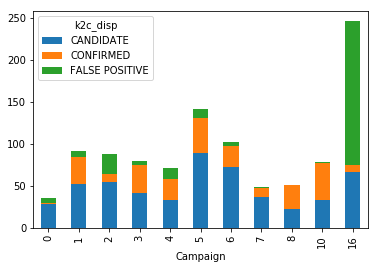

In [5]:
# Count candidates by campaign and disposition (Confirmed, Candidate or False positive)
candidates_count = k2_cands.groupby(['k2_campaign','k2c_disp'])['epic_name'].nunique()
candidates_count = pd.DataFrame(candidates_count)

# Re-index count dataframe including all combinations of k2_campaign and k2c_disp
new_index = pd.MultiIndex.from_product(candidates_count.index.levels,names=candidates_count.index.names)
candidates_count = candidates_count.reindex(new_index, fill_value=0)
candidates_count.reset_index(level=0, inplace=True)
candidates_count.reset_index(level=0, inplace=True)

# Plot stacked bar chart to visualise objects of interest by campaign
piv = candidates_count.pivot(values='epic_name', columns='k2c_disp', index='k2_campaign')
piv.plot.bar(stacked=True)
plt.xlabel('Campaign')

plt.show()

In [6]:
# Compile all kepler fits files for a chosen campaign into a single flux time-series dataset
from flux_load import flux_compiler
campaign = 5
flux_compiler(campaign, k2_cand_names)

25770/25774
Flux data successfully loaded and saved as csv files.


In [6]:
# Load flux datasets for each chosen campaign
try:
    flux_1 = pd.read_csv("Data\c1_lightcurves.csv")
    flux_3 = pd.read_csv("Data\c3_lightcurves.csv")
    flux_5 = pd.read_csv("Data\c5_lightcurves.csv")
    labels_1 = pd.read_csv("Data\c1_labels.csv")
    labels_3 = pd.read_csv("Data\c3_labels.csv")
    labels_5 = pd.read_csv("Data\c5_labels.csv")
    
    flux_1.columns.values[0] = "epic_name"
    flux_3.columns.values[0] = "epic_name"
    flux_5.columns.values[0] = "epic_name"
    labels_1.columns.values[0] = "epic_name"
    labels_3.columns.values[0] = "epic_name"
    labels_5.columns.values[0] = "epic_name"
    
    print('Datasets loaded successfully')
except:
    print("Datasets could not be loaded.")

Datasets loaded successfully


In [7]:
# Calculate length of time-series for each candidate ('label' = 1) in each campaign
flux_len_1 = flux_1.loc[labels_1.index[labels_1['label']==1]].count(axis=1)
flux_len_3 = flux_3.loc[labels_3.index[labels_3['label']==1]].count(axis=1)
flux_len_5 = flux_5.loc[labels_5.index[labels_5['label']==1]].count(axis=1)

In [8]:
# Time-series length statistics for each campaign
print('Campaign 1 time-series lengths:')
print('Min = {:d}'.format(flux_len_1.min()))
print('Max = {:d}'.format(flux_len_1.max()))
print('Mean = {:.0f}'.format(flux_len_1.mean()))

print('\nCampaign 3 time-series lengths:')
print('Min = {:d}'.format(flux_len_3.min()))
print('Max = {:d}'.format(flux_len_3.max()))
print('Mean = {:.0f}'.format(flux_len_3.mean()))

print('\nCampaign 5 time-series lengths:')
print('Min = {:d}'.format(flux_len_5.min()))
print('Max = {:d}'.format(flux_len_5.max()))
print('Mean = {:.0f}'.format(flux_len_5.mean()))

Campaign 1 time-series lengths:
Min = 3286
Max = 3556
Mean = 3530

Campaign 3 time-series lengths:
Min = 2984
Max = 3190
Mean = 3163

Campaign 5 time-series lengths:
Min = 3348
Max = 3457
Mean = 3437


In [16]:
# Combine the flux series from each of the chosen campaigns
flux_raw = pd.concat([flux_1,flux_3,flux_5], ignore_index=True, sort=False)
labels = pd.concat([labels_1,labels_3,labels_5], ignore_index=True, sort=False)
print('Combined flux dataset: size {:d} x {:d}'.format(*flux_raw.shape))

Combined flux dataset: size 64254 x 3556


In [17]:
# Isolate data for all exoplanet candidates in the combined dataset
exoplanet_cands = flux_data.loc[labels.index[labels['label']==1]]

# Calculate length of time-series for each candidate ('label' = 1) in the combined dataset
cands_flux_len = exoplanet_cands.count(axis=1)-1

# Number of exoplanet candidates in the combined dataset
print('The dataset contains {:d} exoplanet candidates.'.format(len(exoplanet_cands)))

# Time-series length statistics
print('\nCombined dataset time-series lenghts:')
print('Min = {:d}'.format(cands_flux_len.min()))
print('Max = {:d}'.format(cands_flux_len.max()))
print('Mean = {:.0f}'.format(cands_flux_len.mean()))

The dataset contains 303 exoplanet candidates.

Combined dataset time-series lenghts:
Min = 2983
Max = 3555
Mean = 3392


In [38]:
# Set minimum time-series length required to keep a given sample in the dataset 
min_flux_len = int(flux_len_3.mean())+1

# Truncate flux dataset by only keeping the first min_flux_len columns
truncated_flux_raw = flux_raw[flux_raw.columns[:min_flux_len]]

In [39]:
# Find rows with missing values (i.e. samples with less than min_flux_len points in their flux time-series)
na_rows = pd.isnull(truncated_flux_raw).any(1).nonzero()[0]

# Remove rows with missing values from the flux and label sets
truncated_flux_data = truncated_flux_raw.drop(truncated_flux_raw.index[na_rows])
truncated_labels = labels.drop(labels.index[na_rows])

In [40]:
# Count number of exoplanet candidates in the truncated dataset
truncated_exoplanet_cands = truncated_flux_data.loc[truncated_labels.index[truncated_labels['label']==1]]
print('The truncated dataset has size {:d} x {:d} and contains {:d} exoplanet candidates.'.format(*truncated_flux_data.shape,len(truncated_exoplanet_cands)))

The truncated dataset has size 60645 x 3163 and contains 279 exoplanet candidates.


In [41]:
import random

# Set random seed to ensure repeatability of random sample selection
random.seed(42)

# Set number of non-exoplanet stars to be included in the dataset
n_non_exoplanet = 4000-len(truncated_exoplanet_cands)

# Randomly select 'n_non_exoplanet' non-exoplanet stars to include in the dataset 
non_exoplanets_sample = random.sample(list(truncated_labels.index[truncated_labels['label']==0]),n_non_exoplanet)

# Indices of exoplanet-candidate stars and selected non-exoplanet stars
full_sample = list(truncated_labels.index[truncated_labels['label']==1]) + non_exoplanets_sample

# Extract the specified sample from the full dataset  
flux_sample = truncated_flux_data.loc[full_sample,:]
labels_sample = truncated_labels.loc[full_sample,:]

# Save flux and label sample datasets
flux_sample.to_csv("Data\\flux_sample.csv")
labels_sample.to_csv("Data\\labels_sample.csv")

---

### Dataset exploration and pre-processing

In [54]:
# Load custom dataset
try:
    flux = pd.read_csv("Data\\flux_sample.csv")
    labels = pd.read_csv("Data\\labels_sample.csv")
    print('Dataset loaded: {} samples with {} features.'.format(*flux.shape))
except:
    print("Training dataset could not be loaded.")

Dataset loaded: 4000 samples with 3164 features.


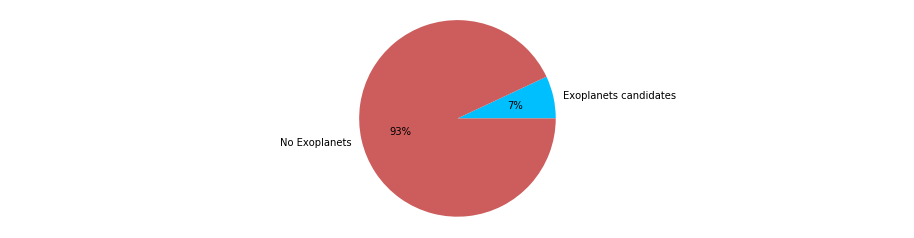

In [67]:
# Count number of exoplanet candidates in the dataset
n_candidates = labels[labels['label']==1].count()['label']

# Plot pie chart for exoplanet-candidate vs non-exoplanet stars in the training and test datasets
fig = plt.figure(figsize=(16,4))
colors = ['deepskyblue','indianred']

plt.pie([n_candidates, flux.shape[0]-n_candidates], colors=colors, 
        labels=['Exoplanets candidates', 'No Exoplanets'], autopct='%1.0f%%') 
plt.axis('equal')
plt.show()